# Proposed System II

## Initialisation

* **Step 1:** Importing Libraries
* **Step 2:** Declaring Constants
* **Step 3:** Accepting Input

---
---

**Step 1:** Importing Libraries

In [58]:
import re
import os
import math
import spacy
import subprocess
import matplotlib.pyplot as plt
from spacy.lang.hi import STOP_WORDS as STOP_WORDS_HI
from wordcloud import WordCloud

**Step 2:** Declaring Constants

In [59]:
# global variables
tf = {}
nlp = spacy.load('hin-dep-parser-treebank')
lendoc = 0

**Step 3:** Accepting Input

In [76]:
article = input("Enter the article name")

Enter the article name4854.txt


## Data Preparation

* **Step 1:**: Extracting Sentences
* **Step 2:**: Cleaning Sentences

---
---

**Step 1:** Extracting Sentences given a file name

In [61]:
def getSent(articleName, directory):
    articleName = directory + '/' + articleName
    f = open(articleName).read()
    sentences = f.split('।')
    return sentences

**Step 2:** Cleaning sentences using basic regex

In [62]:
def cleanSent(unclean):
    clean = []
    for sent in unclean:
        sent = re.sub('\\n', '', sent)
        sent = re.sub('[a-zA-z]', '', sent)
        sent = sent.strip()
        if len(sent) != 0:
            clean.append(sent)
    return clean

## Calculating TF

* **Step 1:** Getting list of all articles
* **Step 2:** Calculating TF
---
---

**Step 1**: Getting list of all documents, cleaning each one, and then sending it to calculate TF

In [63]:
def eachArticle(directory):
    global lendoc
    documents = os.listdir(directory)
    sorted(documents)
    x = 0
    for doc in documents:
        unclean = getSent(doc, directory)
        clean = cleanSent(unclean)
        if len(clean) > 100:
            lendoc += 1
            prepTF(clean, doc)
    print(lendoc)
    return

**Step 2:** Calculating TF of each document using a Lemmatizer

In [64]:
def prepTF(clean, docs):
    global tf
    for sent in clean:
        doc = nlp(sent)
        for w in doc:
            if (w.lemma_, docs) in tf:
                tf[(w.lemma_, docs)] += 1
            else:
                tf[(w.lemma_, docs)] = 1
    return 

**Important: Run this cell only once at the beginning**

In [65]:
eachArticle('valid')

1067


## Generating Summary

* **Step 1:** Calculating TF-IDF given an article
* **Step 2:** Generating the summary based on TF-IDF
---
---

**Step 1:** Generating TF-IDF by generating the IDF and using the global TF variable

In [77]:
def oneArticle(articleName, directory):
    global tf
    global lendoc
    df = {}
    unclean = getSent(articleName, directory)
    clean = cleanSent(unclean)
    documents = os.listdir(directory)    
            
    if len(clean) <= 100:
        prepTF(clean, articleName)
        
    for sent in clean:
        doc = nlp(sent)
        for w in doc:
            if w.lemma_ in df:
                continue
            for docs in documents:
                if (w.lemma_, docs) in tf:
                    if w.lemma_ in df:
                        df[w.lemma_] += tf[(w.lemma_, docs)]
                    else:
                        df[w.lemma_] = tf[(w.lemma_, docs)]
    idf = {}
    for word in df:
        if word not in idf:
            idf[word] = math.log(lendoc/(df[word] + 1))
    
    tfidf = {}
    for word in idf:
        if word not in tfidf:
            tfidf[word] = tf[(word, articleName)] * idf[word]
    
    return tfidf

In [78]:
tfidf = oneArticle(article, 'valid')

**Step 2:** Generating the final summary based on sorting according to TF-IDF of sentences, also adding weights accordingly to represent linguistic heuristic

In [79]:
def getSummary(articleName, directory, tfidf):
    unclean = getSent(articleName, directory)
    clean = cleanSent(unclean)
    heading = clean[0].split(' ')
    slicelen = slice(1, len(clean))
    text = clean[slicelen]
    size = round(0.3 * len(text))
    sent_tfidf = {}
    for sentI in range(0, len(text)):
        w1 = 0
        w2 = 0
        w3 = 0
        sent = text[sentI]
        doc = nlp(sent)
        stfidf = 0
        for w in doc:
            if w.lemma_ not in STOP_WORDS_HI:
                stfidf += tfidf[w.lemma_]
                if w.text in heading:
                    w1 += 15
                if w.tag_ == 'NNP':
                    w2 += 7
                elif str(w.tag_)[0] == 'N':
                    w3 += 5
                    
        sent_tfidf[sentI] = stfidf/len(doc) + w1 + w2 + w3
    sent_tfidf = sorted(sent_tfidf.items(), key = lambda kv:(kv[1], kv[0]), reverse=True)
    sent_limit = []
    for i in range(0, size):
        sent_limit.append(sent_tfidf[i])
    sent_limit = sorted(sent_limit)
    summary = ""
    actual = ""
    for i in sent_limit:
        summary += text[i[0]] + " । " 
    for i in range(0, len(clean)):
        actual += clean[i] + " । "
    summary = clean[0] + " । " + summary
    return actual, summary

In [80]:
actual, summary = getSummary(article, 'valid', tfidf)

## Presenting Output

* **Step 1:** Representing the summary as wordcloud
* **Step 2:** Storing everything externally as a file
---
---

**Step 1:** Generating the wordcloud

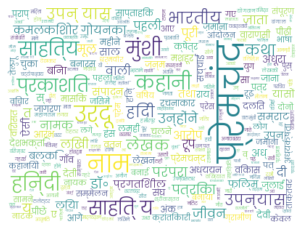

In [81]:
font= "Poppins-Light.ttf"
summary = re.sub("।", '', summary)
wordcloud = WordCloud(
    width=400,
    height=300,
    max_font_size=50, 
    max_words=1000,
    background_color="white", 
    stopwords=STOP_WORDS_HI,
    regexp=r"[\u0900-\u097F]+", 
    font_path=font
).generate(summary)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
name = "summary.png"


**Step 2:** Exporting the summary and wordcloud as external files

In [82]:
wordcloud.to_file(name)
f = open('summary.txt', 'w+')
f.write(summary)
f.close()

In [83]:
subprocess.call(["mv", 'summary.png', "output/"])
subprocess.call(["mv", 'summary.txt', "output/"])

0